In [1]:
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import IncrementalPCA, NMF
from sklearn.preprocessing import Normalizer,StandardScaler
from skimage.color import rgb2gray
from sklearn.neighbors import KDTree, DistanceMetric
from skimage.transform import resize
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
files=glob.glob('./archive/lfw-deepfunneled\lfw-deepfunneled/**/*.jpg',recursive=True)
images=[]
for file in files:
    images.append(rgb2gray(resize(plt.imread(file),(90,90),preserve_range=True,anti_aliasing=True)))
shape=images[0].shape
print(shape)

images_flat=[]
for image in images:
    images_flat.append(image.flatten())
    
Norm=StandardScaler()
Norm.fit(images_flat[0:250])
images_flat_norm=[]
for image in images_flat:
    images_flat_norm.append(Norm.transform([image]))
del images_flat
images_flat_norm=np.asarray(images_flat_norm)[:,0,:]

(90, 90)


In [3]:
num_components=25
batch_size=500  #must be >= num_components
PCA_model=IncrementalPCA(n_components=num_components)
debug_factor=10

i=0
while i<=batch_size*np.floor(len(images)/(batch_size*debug_factor)):
    PCA_model.partial_fit(images_flat_norm[i:min(i+batch_size,len(images_flat_norm))])
    print(f'Now loading images {i} through {i+batch_size}...')
    i+=batch_size

Now loading images 0 through 500...
Now loading images 500 through 1000...
Now loading images 1000 through 1500...


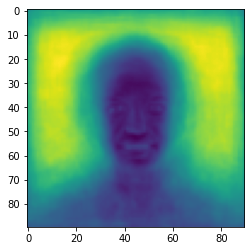

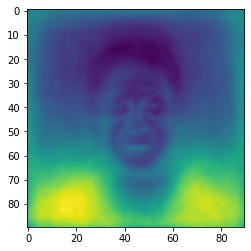

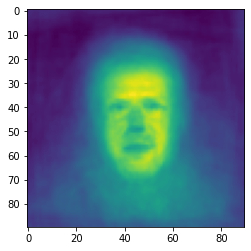

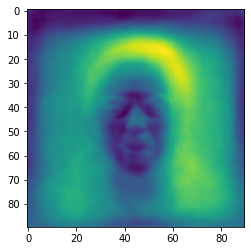

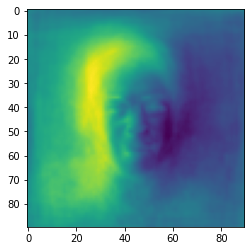

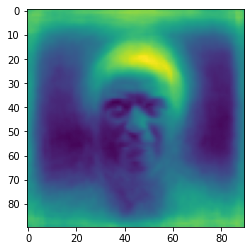

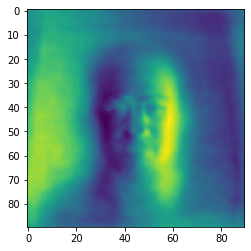

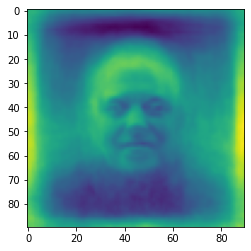

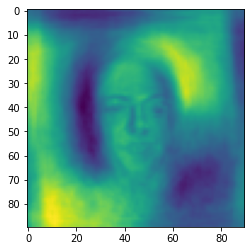

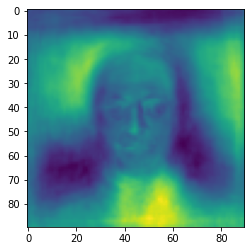

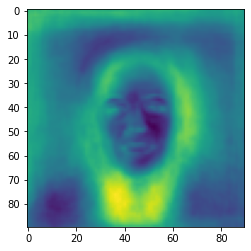

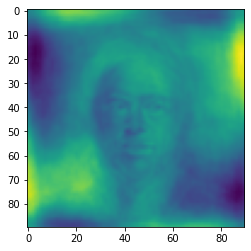

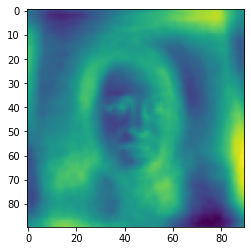

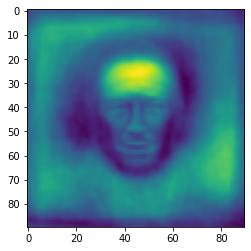

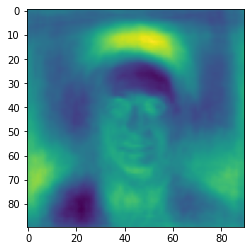

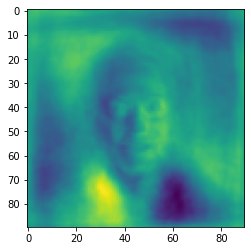

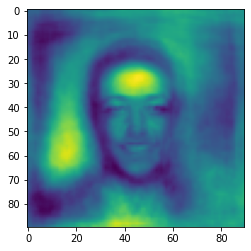

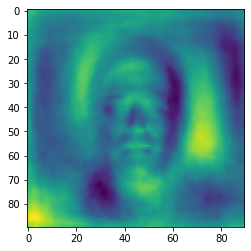

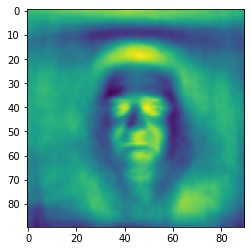

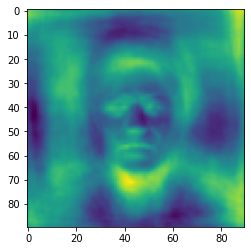

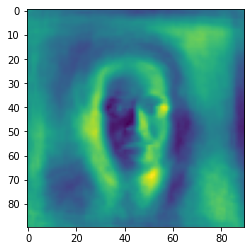

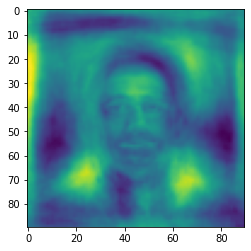

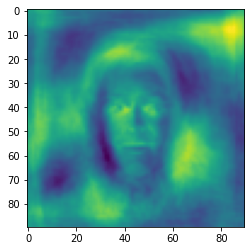

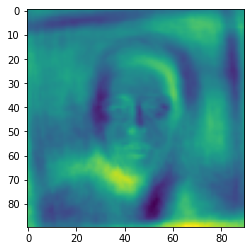

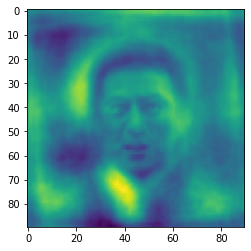

In [4]:
eigenfaces=[]
for i in range(PCA_model.n_components):
    test=PCA_model.components_[i]
    test=test.reshape((shape))
    test=(test+abs(test.min()))*(255/(test.max()-test.min())).astype('uint8')
    eigenfaces.append(test)
for i in range(PCA_model.n_components):
    plt.imshow(eigenfaces[i])
    plt.show()
eigenfaces=[]

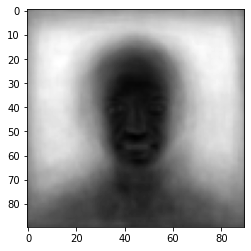

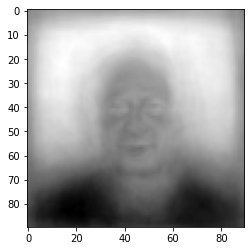

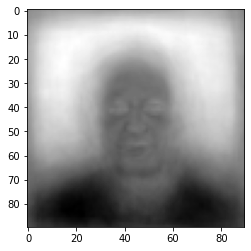

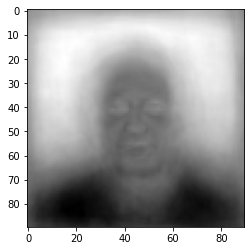

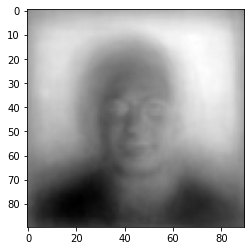

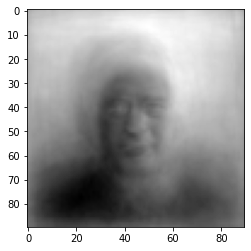

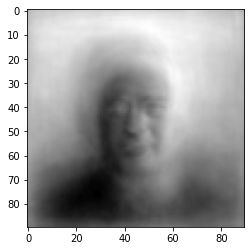

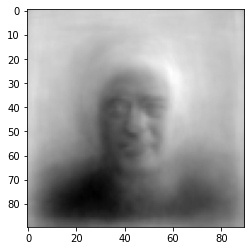

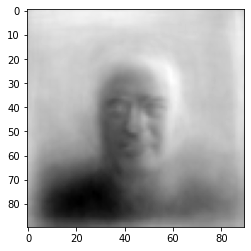

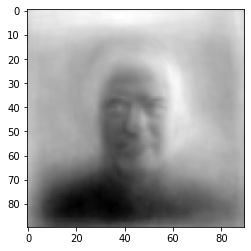

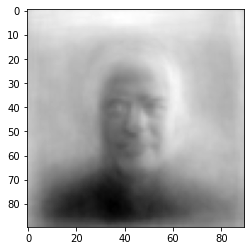

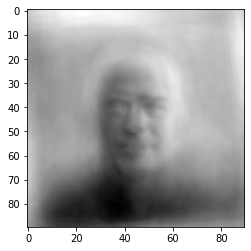

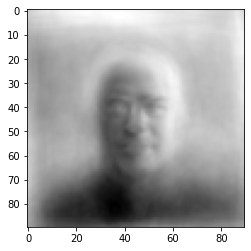

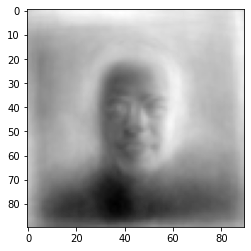

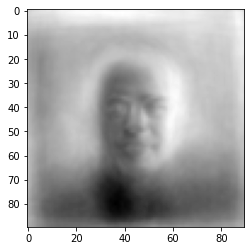

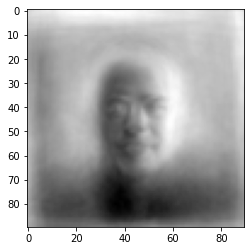

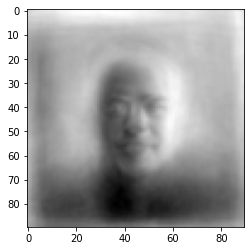

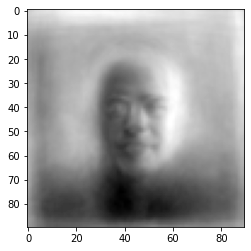

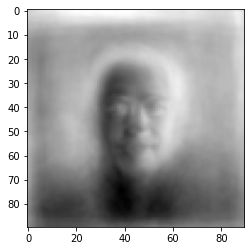

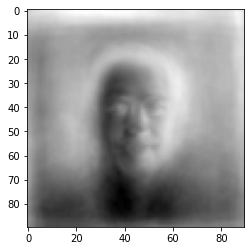

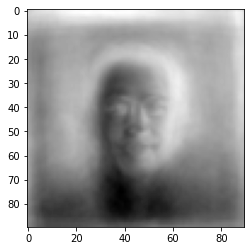

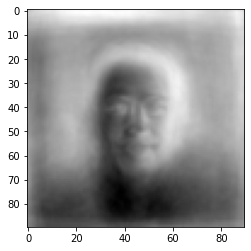

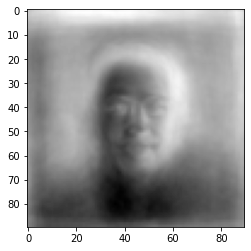

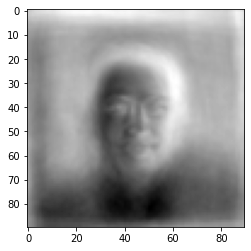

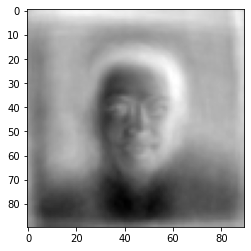

In [5]:
my_img=Norm.transform(rgb2gray(resize(plt.imread("./selfie.jpg"),(90,90),preserve_range=True,anti_aliasing=True)).flatten().reshape(1,-1))
features=PCA_model.transform(my_img)
rebuilt=np.zeros(PCA_model.components_[0].shape)

for i,feature in enumerate(features[0]):
    rebuilt+=PCA_model.components_[i]*feature
    temp_img=abs(rebuilt.min())+rebuilt
    temp_img=temp_img*(255/(temp_img.max()))
    temp_img=temp_img.astype('uint8')
    plt.imshow(temp_img.reshape(shape),cmap='gray')
    plt.show()


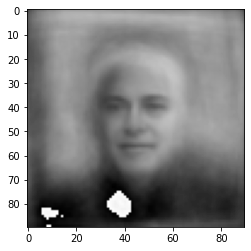

In [6]:
features=PCA_model.transform(my_img)
my_img_rec=PCA_model.inverse_transform(features)
my_img_rec=Norm.inverse_transform(my_img_rec)
plt.imshow(my_img_rec.reshape(shape).astype('uint8'),cmap='gray')

In [7]:
i=0
images_transformed=[]
batch_size=150
debug_factor=1
while i<=batch_size*np.floor(len(images)/(batch_size*debug_factor)):
    images_transformed.extend(PCA_model.transform(images_flat_norm[i:min(i+batch_size,len(images_flat_norm))]))
    i+=batch_size
    
mypic_transformed=PCA_model.transform(my_img)
KDT_model=KDTree(np.asarray(images_transformed),metric='minkowski',p=2)
_,nearest=KDT_model.query(mypic_transformed,k=3)

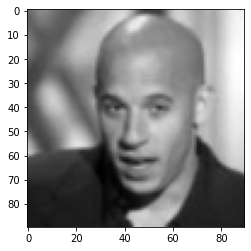

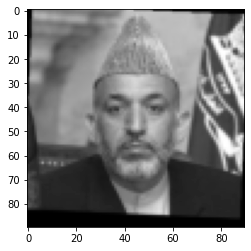

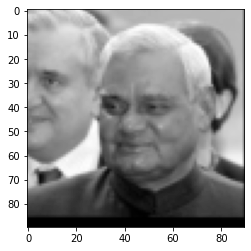

In [8]:
for ind in nearest[0]:
    plt.imshow(images[ind],cmap='gray')
    plt.show()

In [9]:
images_transformed=np.asarray(images_transformed)
sim_max=-1
closest=[-1,-1,-1]
for i,image in enumerate(images_transformed):
    sim=cosine_similarity(mypic_transformed.reshape(1,-1),image.reshape(1,-1))
    if sim>sim_max:
        closest[2]=closest[1]
        closest[1]=closest[0]
        closest[0]=i
        sim_max=sim

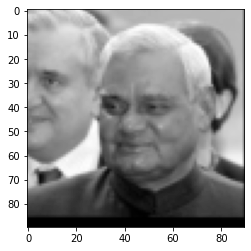

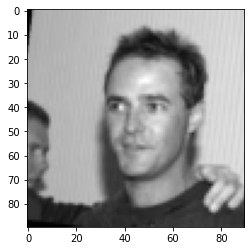

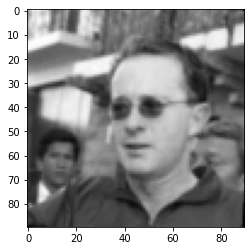

In [11]:
for ind in closest:
    plt.imshow(images[ind],cmap='gray')
    plt.show()

In [16]:
PCA_model.explained_variance_ratio_.sum()

0.6908033991753636